## Assignment

We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.
1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

Instructions
1. Your solution should include these parts:
    - Pre-model Analysis: process and visualize data; get insights of features and target.
    - Problem Definition: translate the business needs into machine learning problems; design metrics to measure model performance.
    - Feature Engineering: create features which might improve model performance.
    - Modeling: Model selection, feature elimination, validation, hyperparameter tuning.
    - Post-model Analysis: Model performance, feature importance, actionable suggestions to business.
2. Use markdown to express your thoughts and findings.
3. Make sure your solution is comprehensive, structured, and easy to follow.
4. Convert your solution into PDF, and submit the PDF file.

## Table of Contents
1. Data cleaning, exploratory analysis, and feature engineering
- 1.1 Target variable processing and visualization
- 1.2 Numeric feature processing and visualization
- 1.3 Feature engineering: time features
- 1.4 Feature engineering: categorical features

2. Build a machine learning model to predict the price for a purchase
- 2.1 Modeling goals and evaluation metrics
- 2.2 Summary of features available for modeling
- 2.3 Building machine learning models
       - (1) Linear regression model (Lasso) with all features
       - (2) Linear regression model (Lasso) with all features sans ingredient
       - (3) Linear regression model (Ridge) with all features
       - (4) Lasso model with power transformation of the cost feature and the price target
       - (5) Random forest model
       - (6) Lasso model with kNN imputation of the cost feature

## Business problem overview

To sustain and potentially further grow business with our customers, for whom we help purchase the product XoX, we need to estimate the price of the product for future purchases. In addition, we should understand the pricing to provide credible insights for our customers. 

The approach to solve this problem is to leverage the historic purchase data, examine the relationship between the purchase price and transaction variables such as time, product properties, and manufacturing features, and translate the relationship to model that can predict the product purchase price. 

Machine learning is well positioned to performed such task. This notebook provides step-by-step explanation of data preprocessing and modeing.

In [1]:
# Import packages for data preprocessing
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data cleaning, exploratory analysis, and feature engineering

In [2]:
# Read data
df = pd.read_csv('./data/sales.csv')
df.dropna(subset=['price'], inplace=True)
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
# Check shape of the dataset
df.shape

(3186, 11)

In [4]:
# Check if the dataset contains duplicate observation; 
# if true, consider to remove the duplicates.
df.duplicated().any()

False

In [5]:
# Overview of missing values for features 

features = list(df.columns)
features.remove('price')

missing_value = []
for f in features:
    missing_value.append(1-df[f].count()/len(df[f]))

missing = pd.Series(missing_value,index=features)
missing.sort_values(ascending=False)

cost             0.306026
maker            0.257690
ingredient       0.079724
depth            0.000942
width            0.000942
weight           0.000942
height           0.000000
product_level    0.000000
product_type     0.000000
purchase_date    0.000000
dtype: float64

A large amount of cost feature (31%) and maker feature (26%) are missing. The ingredient feature also has a notable fraction of missing values (8%). This information is critical, because if we decide to include these features in modeling after some exploratory analysis, we need to address these missing data.

### 1.1 Target variable processing and visualization

To explore the target variable, we need to transform target variable to numeric data.

In [6]:
# Convert price string to numeric (unit: $)   
def price2num(x):
    if type(x) == str:
        x = x.strip('$').replace(',','')
        return float(x)

df['price'] = df['price'].map(price2num)

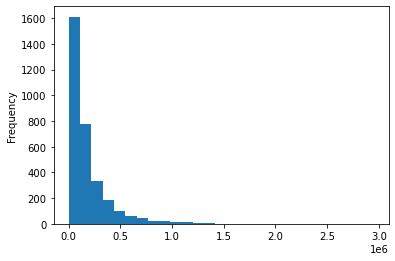

In [7]:
# Visualize target variable distribution
bins = int(1 + 3.322*np.log(df.shape[0]))
df['price'].plot(kind = 'hist',bins=bins)

From the figure above it is obvious that the target variable does not follow a Gaussian distribution. Most of the purchases were done at a lower price. This may not be a concern if later we choose a model that does not assume normal distribution of variables. Just to see if the target variable can be readily transformed to normal distribution, I performed a log transforation here.

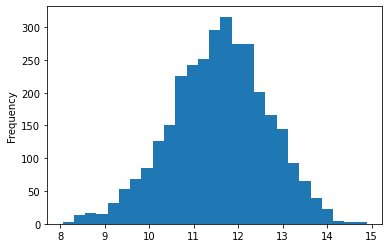

In [8]:
df['price'].map(np.log).plot(kind = 'hist',bins=bins)

In [9]:
from scipy.stats import shapiro
print("p-value obtained from Shapiro-Wilk test : ", shapiro(df['price'].map(np.log))[1])

p-value obtained from Shapiro-Wilk test :  3.142324658256257e-06


Here the p-value from the Shapiro-Wilk test is much smaller than the common threshold α = 0.05, so we can reject null hypothesis, which means the target variable does not follow normal distribution after log transformation. 

Later on if needed, we can use the PowerTransformer class from sklearn library to transform the variable to have a Gaussian distribution. An example is shown below:

### 1.2 Numeric feature processing and visualization

To explore numeric features, we need to transform some values from strings to numeric data type.

In [11]:
# Convert cost string to numeric (unit: $)        
def cost2num(x):
    if type(x) == str:
        x = x.strip('$').strip('k')
        return float(x)*1000
    else:
        return x

# Convert weight string to numeric (unit: kg)
def weight2num( x):
    if type(x) == str:
        x = x.strip('Kg').strip().split(' Ton ')
        return float(x[0])*1000+float(x[1])
    else:
        return x

# Convert height string to numeric (unit: cm)
def height2num(x):
    if type(x) == str:
        x = x.strip('meters').strip()
        return float(x)*100
    else:
        return x        

# Convert width string to numeric (unit: cm)
def width2num(x):
    if type(x) == str:
        x = x.strip('cm').strip()
        return float(x)
    else:
        return x   

# Convert depth string to numeric (unit: cm)
def depth2num(x):
    if type(x) == str:
        x = x.strip('cm').strip()
        return float(x)
    else:
        return x   

df['cost'] = df['cost'].map(cost2num)
df['weight'] = df['weight'].map(weight2num)
df['height'] = df['height'].map(height2num)
df['width'] = df['width'].map(width2num)        
df['depth'] = df['depth'].map(depth2num)

Similar to how we explored the target variable, we would want to look at the distribution of these numeric features. Some of these features may be highly correlated, which could be useful information for unsupervised feature selection, if desired. 

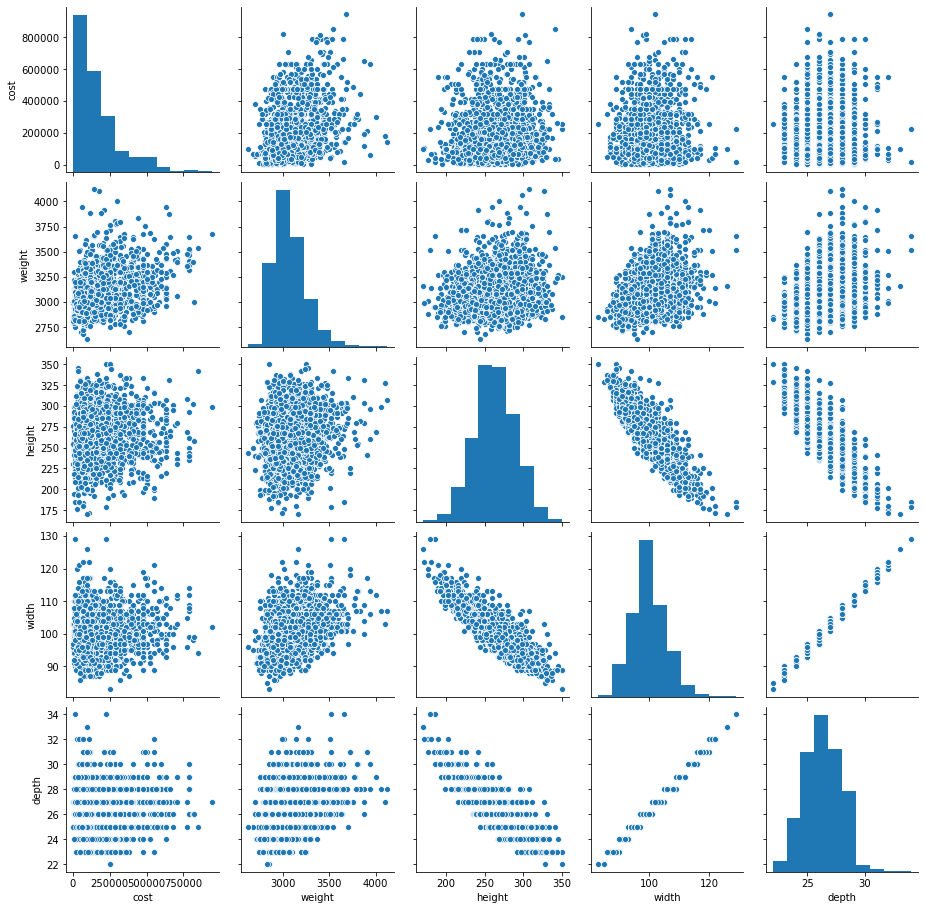

In [12]:
import seaborn as sns
sns.pairplot(df[['cost', 'weight', 'height', 'width', 'depth']])

Visually, the cost feature exhibits an exponential (or lognormal) distribution similar to the target variable, while weight, height, width, and depth exhibit Gussian-like distribution with different degree of skewness. It can be also seen that depth and width exhibit strong positive correlation. Some degree of negative correlation can also be observed between width-height pair and depth-height pair. These observations suggest that we might want to remove some of the highly correlated features or use regularization or PCA if later we choose to build a linear model. The reason is that collinearity raises uncertainty of coefficient estimation and affects feature importance interpretation.

In [18]:
# Calculate the percentage of outliers

num_features = ['cost', 'weight', 'height', 'width', 'depth']

for f in num_features:
    Q1 = df[f].quantile(0.25)
    Q3 = df[f].quantile(0.75)
    IQR = Q3-Q1
    res = df[f][~((df[f]<(Q1-1.5*IQR)) | (df[f]>(Q3+1.5*IQR)))]
    print('Percentage outliers of {0}: {1:.3%}'.format(f, 1-len(res)/len(df)))

Percentage outliers of cost: 3.076%
Percentage outliers of weight: 2.480%
Percentage outliers of height: 0.722%
Percentage outliers of width: 1.507%
Percentage outliers of depth: 0.785%


For this dataset, we do not have strong evidence to justify data removal (one strong evidence could be a known error of the data recording process).

In [13]:
# Build a transformer class to convert string values to numeric values for numerical features

class numeric_transformer:
    ''' 
    Transform any or all of the numerical features
    (cost, weight, height, width, and depth)
    from string values to numeric values.
    Missing values are replaced with means.
    ---
    Input: X, Dataframe (as long as it contains the five features above)
    Output: DataFrame
    '''

    def __init__(self):
        self.mean = 0
    
    def fit(self, X, y=None):
        df_numeric = pd.DataFrame()
        if 'cost' in X.columns:
            df_numeric['cost'] = X['cost'].map(self.cost2num)
        if 'weight' in X.columns:
            df_numeric['weight'] = X['weight'].map(self.weight2num)
        if 'height' in X.columns:
            df_numeric['height'] = X['height'].map(self.height2num)
        if 'width' in X.columns:
            df_numeric['width'] = X['width'].map(self.width2num)        
        if 'depth' in X.columns:
            df_numeric['depth'] = X['depth'].map(self.depth2num)
        self.mean = df_numeric.mean()

    def transform(self, X, y=None):
        df_numeric = pd.DataFrame()
        if 'cost' in X.columns:
            df_numeric['cost'] = X['cost'].map(self.cost2num)
        if 'weight' in X.columns:
            df_numeric['weight'] = X['weight'].map(self.weight2num)
        if 'height' in X.columns:
            df_numeric['height'] = X['height'].map(self.height2num)
        if 'width' in X.columns:
            df_numeric['width'] = X['width'].map(self.width2num)        
        if 'depth' in X.columns:
            df_numeric['depth'] = X['depth'].map(self.depth2num)
        return df_numeric.fillna(self.mean)
 
    def fit_transform(self, X, y=None):       
        self.fit(X)
        return self.transform(X)
        
    # Convert cost string to numeric (unit: $)        
    def cost2num(self, x):
        if type(x) == str:
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

    # Convert weight string to numeric (unit: kg)
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip('Kg').strip().split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
    
    # Convert height string to numeric (unit: cm)
    def height2num(self, x):
        if type(x) == str:
            x = x.strip('meters').strip()
            return float(x)*100
        else:
            return x        
    
    # Convert width string to numeric (unit: cm)
    def width2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

    # Convert depth string to numeric (unit: cm)
    def depth2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

In [14]:
# Quick test of numeric_transformer
numeric_tfm = numeric_transformer()
numeric_new = numeric_tfm.fit_transform(df)
numeric_new.head()

,cost,weight,height,width,depth
0,333000.000000,3090.0,276.0,97.0,26.0
1,169019.448213,3030.0,267.0,98.0,26.0
2,270000.000000,3040.0,300.0,93.0,24.0
3,169019.448213,3050.0,250.0,102.0,27.0
4,97000.000000,2970.0,247.0,101.0,26.0


### 1.3 Feature engineering: time features

Since there is a date attribute, we can extract several time features (e.g., year, month, day, week, weekday, weekend, etc.) to evaluate their importance to predicting price. Instead of adding columns to the dataframe, I create a separate dataframe for date-time features for now.

In [15]:
df_time = pd.DataFrame()
df_time['purchase_date'] = pd.to_datetime(df['purchase_date'])
df_time['year'] = df_time['purchase_date'].dt.year
df_time['month'] = df_time['purchase_date'].dt.month
df_time['day'] = df_time['purchase_date'].dt.day
df_time['weekday'] = df_time['purchase_date'].dt.weekday # Monday=0
df_time['weekday'] = df_time['weekday'].map(lambda x: x+1) # Monday=1
df_time['weekend'] = df_time['weekday']>5
df_time['price'] = df['price']
df_time.head()

,purchase_date,year,month,day,weekday,weekend,price
0,2008-12-19,2008,12,19,5,False,300492.0
1,1997-09-10,1997,9,10,3,False,430570.0
2,2001-09-05,2001,9,5,3,False,213070.0
3,2016-12-23,2016,12,23,5,False,229174.0
4,2000-01-12,2000,1,12,3,False,122659.0


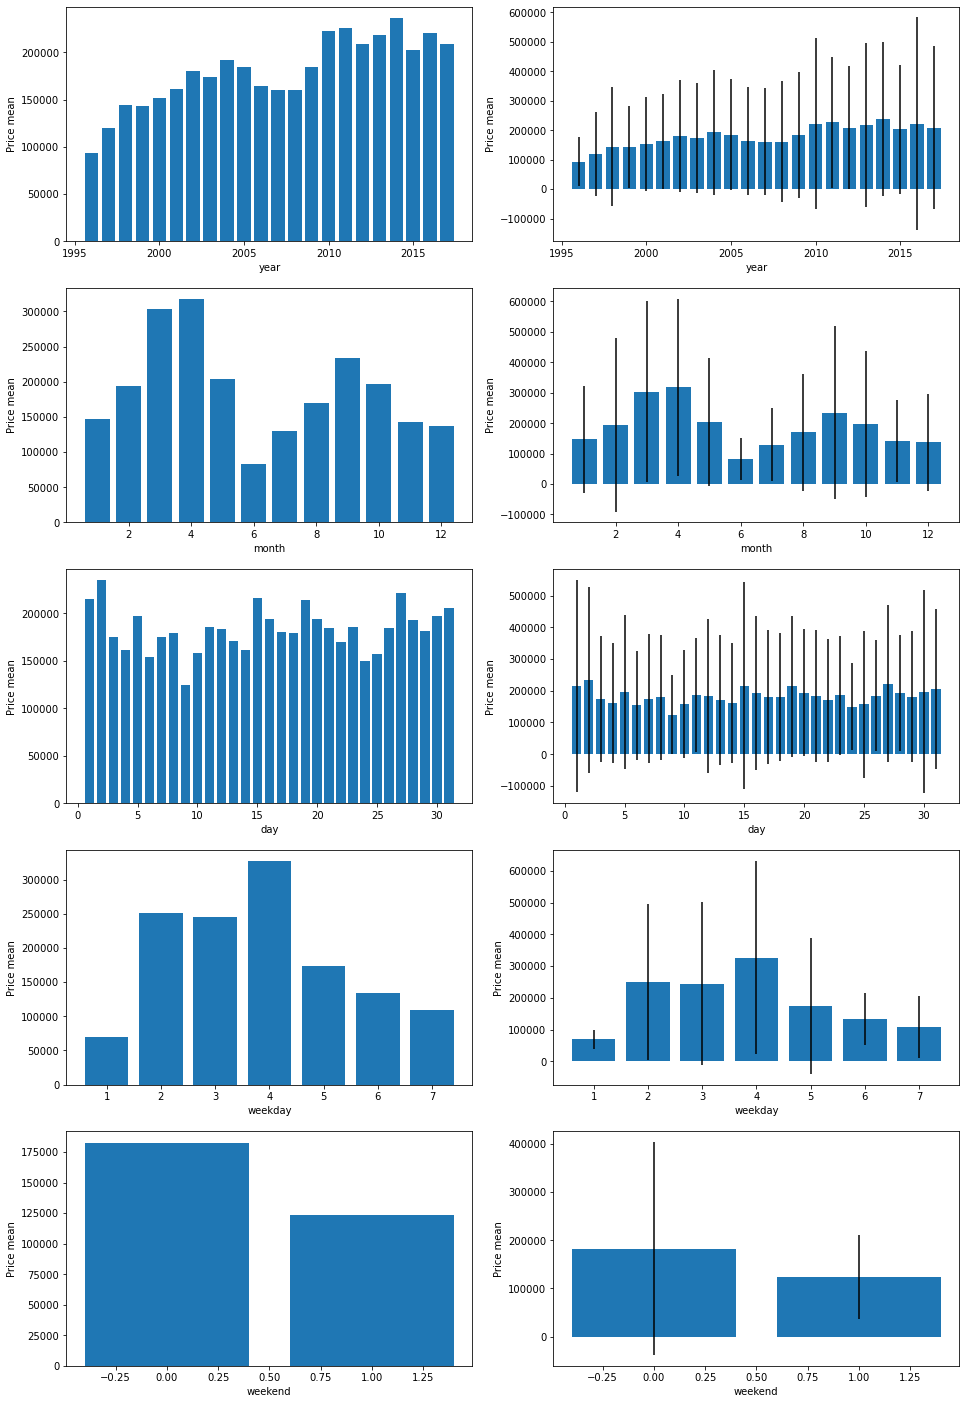

In [16]:
# Plot average price vs data features 

time_features = ['year', 'month', 'day', 'weekday', 'weekend']

def plot_price_feature(df, features):
    
    row = len(features)
    fig, ax = plt.subplots(nrows=row, ncols=2, figsize=(16,25))
    
    for i, f in enumerate(features):
        ax[i,0].bar(df.groupby(f)['price'].groups.keys(),
            df.groupby(f)['price'].mean(), width=0.8, align='center')
        ax[i,1].bar(df.groupby(f)['price'].groups.keys(),
            df.groupby(f)['price'].mean(),
            yerr=df.groupby(f)['price'].std(), width=0.8, align='center')
        ax[i,0].set_xlabel(f)
        ax[i,0].set_ylabel('Price mean')   
        ax[i,1].set_xlabel(f)
        ax[i,1].set_ylabel('Price mean')         

    #plt.tight_layout()
    #plt.show()
        
plot_price_feature(df_time, time_features)

Major observations include:
- Price mean has generally been increasing over the years (except for 2005-2008), which is consistent with economic growth. 
- Price mean exhibits seasonality, with peak values showing in the spring and in the fall. 
- Price mean is higher early in the week (Monday to Wednesday) and lowest during the weekend.
- Price mean does not display any clear trend over different different days in a month. However, we do not have enough domain knowledge to exclude this feature at the moment, and the best way to know it is by testing it.

To tease out the seasonablity information, I further created binary flag features as shown below.

In [17]:
df_time['is_spring'] = df_time['month'].isin(range(3,6))  # Spring: March-May
df_time['is_summer'] = df_time['month'].isin(range(6,9))
df_time['is_fall'] = df_time['month'].isin(range(9,12))
#df_time['is_winter'] = df_time['month'].isin([12,1,2])
df_time.head()

,purchase_date,year,month,day,weekday,weekend,price,is_spring,is_summer,is_fall
0,2008-12-19,2008,12,19,5,False,300492.0,False,False,False
1,1997-09-10,1997,9,10,3,False,430570.0,False,False,True
2,2001-09-05,2001,9,5,3,False,213070.0,False,False,True
3,2016-12-23,2016,12,23,5,False,229174.0,False,False,False
4,2000-01-12,2000,1,12,3,False,122659.0,False,False,False


In [18]:
# Define a transfomer class for purchase_date

class date_transformer:
    '''
    Transform purchase_date to several time features:
    year, month, day, weekday, weekend, is_spring, is_summer, is_fall.
    Transformer does not handle missing value
    ---
    Input: X, Series
    Output: DataFrame
    '''
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df_time = pd.DataFrame()
        df_time['purchase_date'] = pd.to_datetime(X)
        df_time['year'] = df_time['purchase_date'].dt.year
        df_time['month'] = df_time['purchase_date'].dt.month
        df_time['day'] = df_time['purchase_date'].dt.day
        df_time['weekday'] = df_time['purchase_date'].dt.weekday # Monday=0
        df_time['weekday'] = df_time['weekday'].map(lambda x: x+1) # Monday=1
        df_time['weekend'] = df_time['weekday']>5
        df_time['is_spring'] = df_time['month'].isin(range(3,6))  # Spring: March-May
        df_time['is_summer'] = df_time['month'].isin(range(6,9))
        df_time['is_fall'] = df_time['month'].isin(range(9,12))
        #df_time['is_winter'] = df_time['month'].isin([12,1,2])
        df_time.drop(['purchase_date'], axis = 1, inplace=True)
        return df_time

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)        

In [19]:
# Quick test of date_transformer
date_tfm = date_transformer()
date_new = date_tfm.fit_transform(df['purchase_date'])
date_new.head()

,year,month,day,weekday,weekend,is_spring,is_summer,is_fall
0,2008,12,19,5,False,False,False,False
1,1997,9,10,3,False,False,False,True
2,2001,9,5,3,False,False,False,True
3,2016,12,23,5,False,False,False,False
4,2000,1,12,3,False,False,False,False


In [20]:
date_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186 entries, 0 to 3196
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   year       3186 non-null   int64
 1   month      3186 non-null   int64
 2   day        3186 non-null   int64
 3   weekday    3186 non-null   int64
 4   weekend    3186 non-null   bool 
 5   is_spring  3186 non-null   bool 
 6   is_summer  3186 non-null   bool 
 7   is_fall    3186 non-null   bool 
dtypes: bool(4), int64(4)
memory usage: 136.9 KB


### 1.4 Feature engineering: categorical features

Four features in the original dataset are apparently categorical: product_type, product_level, maker, and ingredient. Reminder that the maker variable has 26% values missing, and the ingredient variable has 8% values missing. This information may be useful for us for feature engineering.

Let's examine each variable. 

**(1) product_type**

In [21]:
# Double check the missing value
df['product_type'].isnull().sum()

0

In [22]:
df['product_type'].value_counts()

D      485
H      225
N      203
C      201
U      179
      ... 
N,L      3
T,A      3
R,V      2
O        2
B,R      1
Name: product_type, Length: 64, dtype: int64

It looks like product type is categorized by alphabets, and some observations involve more than one product type. It is unclear at this point that the product type has any ranked ordering. 

There are several possible ways to handle the product_type feature:
- Convert each of the 64 levels to a number (ordinal encoding)
- Create 64 features, one feature for each level (one-hot encoding)
- Create 26 features (26 letters), with "1" indicating the presence of a feature in an observation and "0" indicating the opposite.

Without more information, the last option seems to have the most logical sense so we will start from here.

In [23]:
# Define a transfomer class for product_type

class ptype_transformer:
    '''
    Transform product_type to 26 features (A to Z)
    If value is null, then assign 0 to all features
    ---
    Input: X, Series
    Output: DataFrame
    '''
    def __init__(self):
        self.ptypes = list(string.ascii_uppercase)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        res = {}
        for t in self.ptypes:
            res[t] = [False]*len(X)
        for i in range(len(X)):
            if X.iloc[i]:
                row = X.iloc[i].split(',')
                for j in row:
                    res[j][i] = True
            else:
                Continue
        return pd.DataFrame(res)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [24]:
# Quick test of ptype_transformer
ptype_tfm = ptype_transformer()
product_type_new = ptype_tfm.fit_transform(df['product_type'])
product_type_new.head()

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [25]:
# Check the assumption that product type has 26 levels

product_type_new.nunique()

A    2
B    2
C    2
D    2
E    2
F    2
G    2
H    2
I    2
J    2
K    2
L    2
M    2
N    2
O    2
P    2
Q    2
R    2
S    2
T    2
U    2
V    2
W    2
X    1
Y    1
Z    1
dtype: int64

It turns out that products do not have type "X", "Y", "Z". This is may change over time, but for this particular dataset, we should remove these three features.

The ptype_transformer is updated below to only include product levels that appear in the input. It is possible that later when we split the dataset for training and testing, the test dataset contains levels not in the training dataset. Code is updated to account for this possibility so it won't throw an error.

In [26]:
# Update the ptype_transformer class for product_type

class ptype_transformer:
    '''
    Transform product_type to alphabet features
    If value is null, then assign 0 to all features
    When used for train/test, ignore new levels in test dataset
    ---
    Input: X, Series
    Output: DataFrame
    '''
    def __init__(self):
        self.ptypes = None
    
    def fit(self, X, y=None):
        X1 = X.fillna(0)
        types = set()
        for x in X1:
            if x != 0:
                x = set(x.split(','))
                types = types | x
        self.ptypes = types
   
    def transform(self, X, y=None):
        X1 = X.fillna(0)
        res = {}
        for t in self.ptypes:
            res[t] = [False]*len(X1)
        for i in range(len(X1)):
            if X1.iloc[i] != 0:
                row = X1.iloc[i].split(',')
                for j in row:
                    if j in res:
                        res[j][i] = True
                    else:
                        print('New product level {} is detected.'.format(j))
            else:
                Continue
        return pd.DataFrame(res)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [27]:
# Quick test of updated ptype_transformer
ptype_tfm = ptype_transformer()
product_type_new = ptype_tfm.fit_transform(df['product_type'])
product_type_new.head()

,L,W,P,J,S,N,V,G,E,M,...,Q,A,R,D,F,H,I,K,C,U
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False


**(2) product_level**

In [28]:
# Double check the missing value
df['product_level'].isnull().sum()

0

In [29]:
df['product_level'].value_counts()

advanced          1320
super advanced    1222
intermediate       532
basic              111
unrated              1
Name: product_level, dtype: int64

The product_level feature has five levels: unrated, basic, intermediate, advanced, and super advanced. Since there is only one observation, I will replace the value "unrated" with the most common value (in this particular dataset "advanced") to simply the levels. 

There are two obvious ways to handle the product_level feature:
- Ordinal encoding
- One-hot encoding or dummy encoding

Based on the name of the level, it's possible that there is some natural ordering. For example, basic is the lowest level and super advanced is the highest level. Let's start with ordinal encoding.

In [30]:
# Define a transfomer class for product_level

class plevel_transformer:
    '''
    Transform product_level with ordinal encoding
    basic -> 0, intermediate -> 1, 
    advanced -> 2, super advanced -> 3
    unrated is replaced by the most common level
    null value is also replaced by the most common level
    ---
    Input: X, Series
    Output: DataFrame
    '''
    def __init__(self):
        self.ptypes = ['basic', 'intermediate', 'advanced', 'super advanced']
        self.ptype_mode = None
    
    def fit(self, X, y=None):
        self.ptype_mode = X.value_counts().index[0]
        return self.ptype_mode
    
    def transform(self, X, y=None):
        X1 = X.fillna(self.ptype_mode)
        X1.replace(to_replace='unrated', value=self.ptype_mode, inplace=True)
        X1.replace({'basic': 0, 'intermediate': 1,
                   'advanced': 2, 'super advanced': 3}, inplace=True)
        return pd.DataFrame(X1)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [31]:
# Quick test of plevel_transformer
plevel_tfm = plevel_transformer()
plevel_tfm.fit_transform(df['product_level'])

,product_level
0,2
1,0
2,0
3,2
4,2
...,...
3192,2
3193,1
3194,1
3195,2


**(3) maker**

In [32]:
# Double check the missing value
df['maker'].isnull().sum()

821

In [33]:
df['maker'].value_counts()

M14196           17
M14346           16
M14170           15
M14163           15
M14164           13
                 ..
M14269,M14559     1
M14564            1
M14805            1
M14849            1
M14268            1
Name: maker, Length: 879, dtype: int64

In [34]:
df['maker'].str.split(',').explode().value_counts()

M14196    17
M14346    16
M14163    15
M14170    15
M14565    14
          ..
M14990     1
M14867     1
M14925     1
M14580     1
M14268     1
Name: maker, Length: 888, dtype: int64

The maker feature has 879 levels with a total number of 888 unique maker values. If we are to do the same type of transformation as we did with the product_type feature, it will create 888 features. If we are to use one-hot encoding, it will create 879 features. It may be possible to do ordinal encoding as we did for product_level, we there is no information indicating a natural order in this feature.

Without domain knowledge (this is one of the things that we can get more information from colleagues or business partners if we were working on a real case), it is hard to tell what is the most reasonable approach to transform this feature. Another challenge related to the lack of domain knowledge is how to deal with missng value. Remember that this feature has the highest percentage of missing value (26%). 

Due to the considerations above, I decided not to include the maker feature in modeling. If more information become available in the future, we can revisit this feature and test how much it may improve the model. 

**(4) ingredient**

In [35]:
# Double check the missing value
df['ingredient'].isnull().sum()

254

In [36]:
df['ingredient'].value_counts()

IN732638                                                                            8
IN732362                                                                            6
IN732832                                                                            4
IN732200                                                                            4
IN732502                                                                            4
                                                                                   ..
IN732564,IN732616,IN732674,IN732487,IN733721,IN733414,IN733722                      1
IN732063,IN732531,IN732645,IN733062,IN732077,IN732875,IN732243,IN733189,IN733572    1
IN732386,IN733112,IN733397,IN732309,IN732226,IN732921                               1
IN732832,IN732804                                                                   1
IN732562,IN733052,IN732067,IN732494,IN733128,IN732612                               1
Name: ingredient, Length: 2824, dtype: int64

In [37]:
df['ingredient'].str.split(',').explode().value_counts()

IN732658    64
IN732094    51
IN732489    44
IN732074    42
IN732583    41
            ..
IN732915     1
IN733805     1
IN733552     1
IN733957     1
IN733729     1
Name: ingredient, Length: 2035, dtype: int64

Similar to the maker feature, the ingredient feature has a large number of levels (2824) and a large number of unique ingredient values (2035). At the same time, it also has a decent amount of missing values (8%). 

Intuitively, we may think that some ingredients are more expensive than others and contribute to higher price. Therefore, it would be reasonable to test how much information this feature brings to the predictive model and only discard it if results suggest little/no positive effect.

In [38]:
# Define a transfomer class for ingredient

class ingredient_transformer:
    '''
    Transform ingredient to single-ingredient features
    If value is null, assign a new level INunknown
    When used for train/test, ignore new levels in test dataset
    ---
    Input: X, Series
    Output: DataFrame
    '''
    def __init__(self, show_new_ingredient=False):
        self.show_new_ingredient = show_new_ingredient
        self.ingredients = None
    
    def fit(self, X, y=None):
        X1 = X.fillna('INunknown')
        ingredients = set()
        for x in X1:
            x = set(x.split(','))
            ingredients = ingredients | x
        self.ingredients = ingredients
    
    def transform(self, X, y=None):
        X1 = X.fillna('INunknown')
        res = {}
        for t in self.ingredients:
            res[t] = [False]*len(X1)
        for i in range(len(X1)):
            row = X1.iloc[i].split(',')
            for j in row:
                if j in res:
                    res[j][i] = True
                else:
                    if self.show_new_ingredient:
                        print('New product ingredient {} is detected.'.format(j))
        return pd.DataFrame(res)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [39]:
# Quick test of ingredient_transformer
ingredient_tfm = ingredient_transformer()
ingredient_new = ingredient_tfm.fit_transform(df['ingredient'])
ingredient_new.head()

,IN732277,IN733417,IN733034,IN733424,IN733407,IN733858,IN732228,IN732859,IN732582,IN733763,...,IN733720,IN733184,IN732284,IN732943,IN733700,IN733145,IN733909,IN734019,IN732729,IN732373
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 2. Build a machine learning model to predict the price for a purchase

### 2.1 Modeling goals and evaluation metrics

Modeling goals are two-fold: (1) predict purchase price with high accuracy; (2) allow extraction of insight of the predicted price. 

Model performance will be evaluated by how well it can describe the data used to train the model and how well it predicts unseen data. Ideally, we would like to get a model that can describe the training data well (low bias) and can translate the prediction skill to the testing data, which the model has never seen (low variance). 

Three performance metrics are utilized:
1. Mean absolute error (MAE): a measure of absolute difference between two variables.
2. Mean squared error (MSE): measures the average of the squares of the errors. It's good to use MSE if the data has a lot of outliers. The square will emphasize on the outlier errors.
3. R squared (R2): represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. It does not take into consideration any biases that might be present in the data. Sometimes a good model might have a low R squared value while a not so great model can have a high R squared value.

### 2.2 Summary of features available for modeling

**(1) Numerical features**<br>
Can use numeric_transformer to transform string values to numeric values for any or all of the five features (cost, weight, height, width, and depth) by passing a Dataframe input; missing values are replaced by mean values.
    
- cost: exhibits an exponential (or lognormal) distribution similar to the target variable.
- weight: exhibits Gussian-like distribution.
- depth: exhibits Gussian-like distribution and strong positive correlation with depth.
- widthh: exhibits Gussian-like distribution and strong positive correlation with width.
- height: exhibits Gussian-like distribution, also exhibits some degree of negative correlation with depth and width.

**(2) Time features**<br>
Features from the purchase_date feautre; can be transformed using date_transformer class by passing a Series input.
    
- year: price mean has generally been increasing over the years (except for 2005-2008).
- month: price mean exhibits seasonality, with peak values showing in the spring and in the fall.
- is_spring, is_summer, is_fall: binary flag features for testing the seasonablity.
- weekday: price mean is higher early in the week (Monday to Wednesday) and lowest during the weekend.
- weekend: binar flag feature for testing if weekend itself is an important factor.
- day: price mean does not display any clear trend over different different days in a month; however, we do not have enough domain knowledge to exclude this feature at the moment, and the best way to know it is by testing it.

**(3) Categorical features**
    
- product_type: encoded by individual product type (a subset of alphabet, may not have all 26 letters); can be transformed using the ptype_transformer class by passing a Series input.
- product_level: ordinally encoded (basic -> 0, intermediate -> 1, advanced -> 2, super advanced -> 3, unrated is replaced by the most common level); can be transformed using the plevel_transformer class by passing a Series input.
- ingredient: encoded by individual ingredient (may have hundreds to thousands of features); can be transformed using the ingredient_transformer class by passing a Series input.

### 2.3 Building machine learning models

In [40]:
# Import packages for modeling
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

Define some classes to help build pipelines.

In [41]:
# Define a selector class to select feature as input
class FeatureSelector:
    def __init__(self, feature):
        self.feature = feature
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.feature]

# Define a transformer class to return data without scaling 
class NoScaler(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

Allocate training and testing dataset. 

In [42]:
# Re-read raw data to eliminate any possible changes on data from exploratory analysis
df = pd.read_csv('./data/sales.csv')
df.dropna(subset=['price'], inplace=True)

X = df.drop(['price'], axis=1)
y = df['price']

# Convert price string to numeric (unit: $)   
def price2num(x):
    if type(x) == str:
        x = x.strip('$').replace(',','')
        return float(x)

y = y.map(price2num)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # !Need to reset index
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [44]:
print('Shape of X_train, y_train, X_test, and y_test is: {}, {}, {}, {}.'
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shape of X_train, y_train, X_test, and y_test is: (2548, 10), (2548,), (638, 10), (638,).


**(1) Linear regression model (Lasso) with all features**

In [46]:
# Get numerical features ready for scaling/modeling
# no power transformation
numeric_t = numeric_transformer()

# Get time features ready for scaling/modeling
date_t = Pipeline([
    ('selector', FeatureSelector('purchase_date')),
    ('date_tfm', date_transformer())
    ])

# Get categorical features ready for modeling    
ptype_t = Pipeline([
    ('selector', FeatureSelector('product_type')),
    ('ptype_tfm', ptype_transformer())
    ])
plevel_t = Pipeline([
    ('selector', FeatureSelector('product_level')),
    ('plevel_tfm', plevel_transformer())
    ])    
ingredient_t = Pipeline([
    ('selector', FeatureSelector('ingredient')),
    ('ingredient_tfm', ingredient_transformer())
    ]) 

# Transform training set to a DataFrame ready for further scaling or modeling
tfms = [numeric_t, date_t, ptype_t, plevel_t, ingredient_t]    

X_train_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.fit_transform(X_train))
    X_train_tfm = pd.concat([X_train_tfm, df_sub], axis = 1)

X_train_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,395000.000000,3380.0,267.0,104.0,27.0,2015,1,9,5,False,...,False,False,False,False,False,False,False,False,False,False
1,169135.774648,2880.0,238.0,101.0,27.0,2012,12,14,5,False,...,False,False,False,False,False,False,False,False,False,False
2,66000.000000,3040.0,269.0,98.0,26.0,2010,12,24,5,False,...,False,False,False,False,False,False,False,False,False,False
3,169135.774648,3210.0,253.0,104.0,27.0,1999,6,25,5,False,...,False,False,False,False,False,False,False,False,False,False
4,169135.774648,3110.0,258.0,101.0,26.0,1996,11,29,5,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
X_test_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.transform(X_test))
    X_test_tfm = pd.concat([X_test_tfm, df_sub], axis = 1)

X_test_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,317000.000000,2990.0,289.0,94.0,25.0,2007,9,28,5,False,...,False,False,False,False,False,False,False,False,False,False
1,23000.000000,3130.0,291.0,96.0,25.0,2012,2,17,5,False,...,False,False,False,False,False,False,False,False,False,False
2,169135.774648,2980.0,260.0,99.0,26.0,2008,11,7,5,False,...,False,False,False,False,False,False,False,False,False,False
3,254000.000000,3470.0,269.0,105.0,27.0,2001,10,5,5,False,...,False,False,False,False,False,False,False,False,False,False
4,144000.000000,2840.0,253.0,98.0,26.0,2001,4,6,5,False,...,False,False,False,False,False,False,False,False,False,False


In [48]:
# Define how to scale the features
numerical_col = X_train_tfm.select_dtypes(include=['int64', 'float64']).columns
categorical_col = X_train_tfm.select_dtypes(include=['object', 'bool']).columns
scale_numeric = ColumnTransformer(transformers=[
    ('num_scale', MinMaxScaler(), numerical_col),
    ('cat_scale', NoScaler(), categorical_col)
    ])

In [49]:
# Tune hyperparameter for Lasso model
X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_train_tfm, y_train, test_size=0.33, random_state=0)
training_error = []
validation_error = []

alphas = range(250, 451, 25) # Manually iterated on value range

for alpha in alphas:
    # Build Lasso pipeline
    steps = [('scale', scale_numeric),
             ('lasso', Lasso(alpha=alpha, random_state=0, max_iter=10000))]
    lasso_pipeline = Pipeline(steps)
    lasso_pipeline.fit(X_tune_train, y_tune_train)
    training_error.append(mean_squared_error(y_tune_train, lasso_pipeline.predict(X_tune_train)))
    validation_error.append(mean_squared_error(y_tune_test, lasso_pipeline.predict(X_tune_test)))

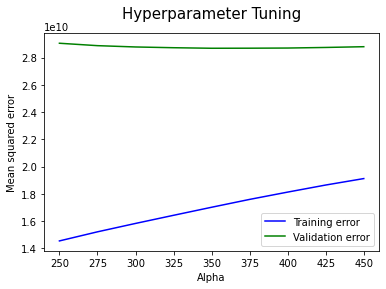

In [50]:
# Hyperparameter tuning visualization 
plt.plot(alphas, training_error, color='blue', label='Training error')
plt.plot(alphas, validation_error, color='green', label='Validation error')
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
#plt.ylim([])
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

In [51]:
# Set alpha = 350 based on hyperparameter tuning results
steps = [('scale', scale_numeric),
         ('lasso', Lasso(alpha=350, random_state=0))]
lasso_pipeline = Pipeline(steps)
lasso_pipeline.fit(X_train_tfm, y_train)

# Evaluate model performance
print("Train loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_train,lasso_pipeline.predict(X_train_tfm)),
             mean_squared_error(y_train,lasso_pipeline.predict(X_train_tfm)),
            r2_score(y_train,lasso_pipeline.predict(X_train_tfm))))
print("Test loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_test,lasso_pipeline.predict(X_test_tfm)),
             mean_squared_error(y_test,lasso_pipeline.predict(X_test_tfm)),
            r2_score(y_test,lasso_pipeline.predict(X_test_tfm))))   

Train loss metrics (MAE, MSE, R2) are: (9.84e+04, 2.01e+10, 0.571)
Test loss metrics (MAE, MSE, R2) are: (1.11e+05, 3.56e+10, 0.364)


In [52]:
lasso_pipeline_coef = lasso_pipeline.steps[1][1].coef_

In [53]:
# Uncomment the line below to view the coefficients
#lasso_pipeline_coef.tolist()

Text(0.5, 1.0, 'Feature Importance')

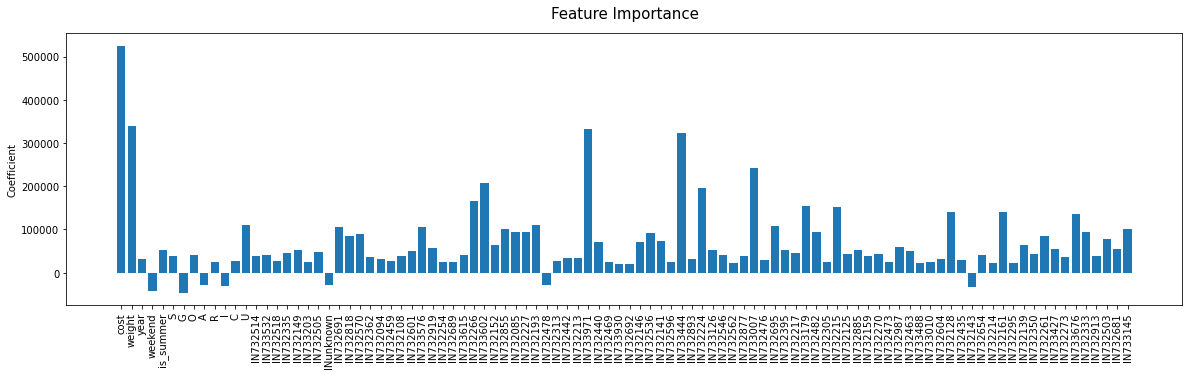

In [54]:
# Visualize the feature importance
coeff_cutoff = 20000
large_features = X_train_tfm.columns[np.abs(lasso_pipeline_coef)>coeff_cutoff]
coeff = lasso_pipeline_coef[np.abs(lasso_pipeline_coef)>coeff_cutoff]
plt.figure(figsize=(20,5))
plt.bar(x=large_features, height=coeff)
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)

It was observed that cost and weight have the highest feature importance. Many of the ingredients have low weights but some (e.g., IN733911, IN733444, IN733007) have relatively high weights. However, these ingredients may be only found in one example, so their value for prediction may be small and needs to be further assessed. When setting show_new_ingredient=True, it was also observed that the test dataset has dozens of new ingredients, which were not included in the model.

**(2) Linear regression model (Lasso) with all features sans ingredient**

In [55]:
# Get numerical features ready for scaling/modeling
# no power transformation
numeric_t = numeric_transformer()

# Get time features ready for scaling/modeling
date_t = Pipeline([
    ('selector', FeatureSelector('purchase_date')),
    ('date_tfm', date_transformer())
    ])

# Get categorical features ready for modeling    
ptype_t = Pipeline([
    ('selector', FeatureSelector('product_type')),
    ('ptype_tfm', ptype_transformer())
    ])
plevel_t = Pipeline([
    ('selector', FeatureSelector('product_level')),
    ('plevel_tfm', plevel_transformer())
    ])    

# Transform training set to a DataFrame ready for further scaling or modeling
tfms = [numeric_t, date_t, ptype_t, plevel_t]    

X_train_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.fit_transform(X_train))
    X_train_tfm = pd.concat([X_train_tfm, df_sub], axis = 1)

X_train_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,A,R,D,F,H,I,K,C,U,product_level
0,395000.000000,3380.0,267.0,104.0,27.0,2015,1,9,5,False,...,False,False,False,False,True,False,False,False,False,2
1,169135.774648,2880.0,238.0,101.0,27.0,2012,12,14,5,False,...,False,False,True,False,False,False,False,False,False,3
2,66000.000000,3040.0,269.0,98.0,26.0,2010,12,24,5,False,...,False,True,True,False,False,False,False,False,False,3
3,169135.774648,3210.0,253.0,104.0,27.0,1999,6,25,5,False,...,False,False,False,True,True,False,False,False,False,3
4,169135.774648,3110.0,258.0,101.0,26.0,1996,11,29,5,False,...,False,False,False,False,True,False,False,False,True,3


In [56]:
X_test_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.transform(X_test))
    X_test_tfm = pd.concat([X_test_tfm, df_sub], axis = 1)

X_test_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,A,R,D,F,H,I,K,C,U,product_level
0,317000.000000,2990.0,289.0,94.0,25.0,2007,9,28,5,False,...,False,False,False,False,False,False,True,False,False,1
1,23000.000000,3130.0,291.0,96.0,25.0,2012,2,17,5,False,...,False,False,True,False,False,False,False,False,False,2
2,169135.774648,2980.0,260.0,99.0,26.0,2008,11,7,5,False,...,False,False,False,False,True,False,False,False,False,2
3,254000.000000,3470.0,269.0,105.0,27.0,2001,10,5,5,False,...,True,False,False,False,True,False,False,False,False,2
4,144000.000000,2840.0,253.0,98.0,26.0,2001,4,6,5,False,...,False,False,False,False,False,False,False,True,False,0


In [57]:
# Define how to scale the features
numerical_col = X_train_tfm.select_dtypes(include=['int64', 'float64']).columns
categorical_col = X_train_tfm.select_dtypes(include=['object', 'bool']).columns
scale_numeric = ColumnTransformer(transformers=[
    ('num_scale', MinMaxScaler(), numerical_col),
    ('cat_scale', NoScaler(), categorical_col)
    ])

In [58]:
# Tune hyperparameter for Lasso model
X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_train_tfm, y_train, test_size=0.33, random_state=0)
training_error = []
validation_error = []

alphas = [0.01, 0.03, 0.1, 0.3, 1, 10] # Manually iterated on value range

for alpha in alphas:
    # Build Lasso pipeline
    steps = [('scale', scale_numeric),
             ('lasso', Lasso(alpha=alpha, random_state=0, max_iter=10000))]
    lasso_pipeline = Pipeline(steps)
    lasso_pipeline.fit(X_tune_train, y_tune_train)
    training_error.append(mean_squared_error(y_tune_train, lasso_pipeline.predict(X_tune_train)))
    validation_error.append(mean_squared_error(y_tune_test, lasso_pipeline.predict(X_tune_test)))

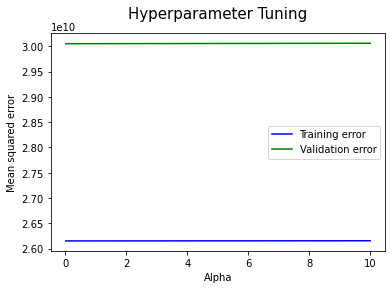

In [59]:
# Hyperparameter tuning visualization 
plt.plot(alphas, training_error, color='blue', label='Training error')
plt.plot(alphas, validation_error, color='green', label='Validation error')
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
#plt.ylim([])
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

In [60]:
# Set alpha = 1 based on hyperparameter tuning results
steps = [('scale', scale_numeric),
         ('lasso', Lasso(alpha=1, random_state=0))]
lasso_pipeline = Pipeline(steps)
lasso_pipeline.fit(X_train_tfm, y_train)

# Evaluate model performance
print("Train loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_train,lasso_pipeline.predict(X_train_tfm)),
             mean_squared_error(y_train,lasso_pipeline.predict(X_train_tfm)),
            r2_score(y_train,lasso_pipeline.predict(X_train_tfm))))
print("Test loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_test,lasso_pipeline.predict(X_test_tfm)),
             mean_squared_error(y_test,lasso_pipeline.predict(X_test_tfm)),
            r2_score(y_test,lasso_pipeline.predict(X_test_tfm))))   

Train loss metrics (MAE, MSE, R2) are: (1.12e+05, 2.72e+10, 0.418)
Test loss metrics (MAE, MSE, R2) are: (1.19e+05, 3.71e+10, 0.336)


Linear regression model (Lasso) with all features:
- Train loss metrics (MAE, MSE, R2) are: (9.84e+04, 2.01e+10, 0.571)
- Test loss metrics (MAE, MSE, R2) are: (1.11e+05, 3.55e+10, 0.364)

Linear regression model (Lasso) with all features sans ingredient:
- Train loss metrics (MAE, MSE, R2) are: (1.12e+05, 2.72e+10, 0.418)
- Test loss metrics (MAE, MSE, R2) are: (1.19e+05, 3.71e+10, 0.336)

The Lasso model with ingredient features showed lower errors, so it may be desirable to keep the ingredient features in the model.

Text(0.5, 1.0, 'Feature Importance')

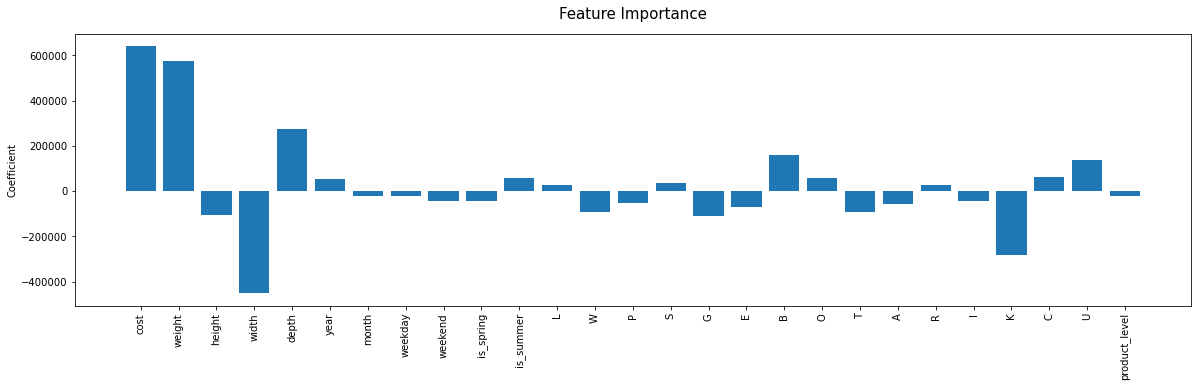

In [61]:
# Visualize the feature importance
lasso_pipeline_coef = lasso_pipeline.steps[1][1].coef_

coeff_cutoff = 20000
large_features = X_train_tfm.columns[np.abs(lasso_pipeline_coef)>coeff_cutoff]
coeff = lasso_pipeline_coef[np.abs(lasso_pipeline_coef)>coeff_cutoff]
plt.figure(figsize=(20,5))
plt.bar(x=large_features, height=coeff)
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)

**(3) Linear regression model (Ridge) with all features**

Lasso model is has built-in feature selection and robust to outlier but cannot learn complex pattern. Therefore, Ridge model is also built to test its predict ability.

In [62]:
# Tune hyperparameter for Ridge model
training_error = []
validation_error = []

alphas = [0.01, 0.03, 0.1, 0.3, 1, 3] # Manually iterated on value range

for alpha in alphas:
    # Build Ridge pipeline
    steps = [('scale', scale_numeric),
             ('ridge', Ridge(alpha=alpha, random_state=0))]
    ridge_pipeline = Pipeline(steps)
    ridge_pipeline.fit(X_tune_train, y_tune_train)
    training_error.append(mean_squared_error(y_tune_train, ridge_pipeline.predict(X_tune_train)))
    validation_error.append(mean_squared_error(y_tune_test, ridge_pipeline.predict(X_tune_test)))

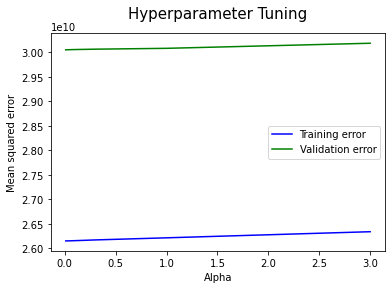

In [63]:
# Hyperparameter tuning visualization 
plt.plot(alphas, training_error, color='blue', label='Training error')
plt.plot(alphas, validation_error, color='green', label='Validation error')
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
#plt.ylim([])
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

In [64]:
# Set alpha = 0.01 based on hyperparameter tuning results
steps = [('scale', scale_numeric),
         ('ridge', Ridge(alpha=0.01, random_state=0))]
ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train_tfm, y_train)

# Evaluate model performance
print("Train loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_train,ridge_pipeline.predict(X_train_tfm)),
             mean_squared_error(y_train,ridge_pipeline.predict(X_train_tfm)),
            r2_score(y_train,ridge_pipeline.predict(X_train_tfm))))
print("Test loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_test,ridge_pipeline.predict(X_test_tfm)),
             mean_squared_error(y_test,ridge_pipeline.predict(X_test_tfm)),
            r2_score(y_test,ridge_pipeline.predict(X_test_tfm))))   

Train loss metrics (MAE, MSE, R2) are: (1.12e+05, 2.72e+10, 0.418)
Test loss metrics (MAE, MSE, R2) are: (1.19e+05, 3.71e+10, 0.336)


Text(0.5, 1.0, 'Feature Importance')

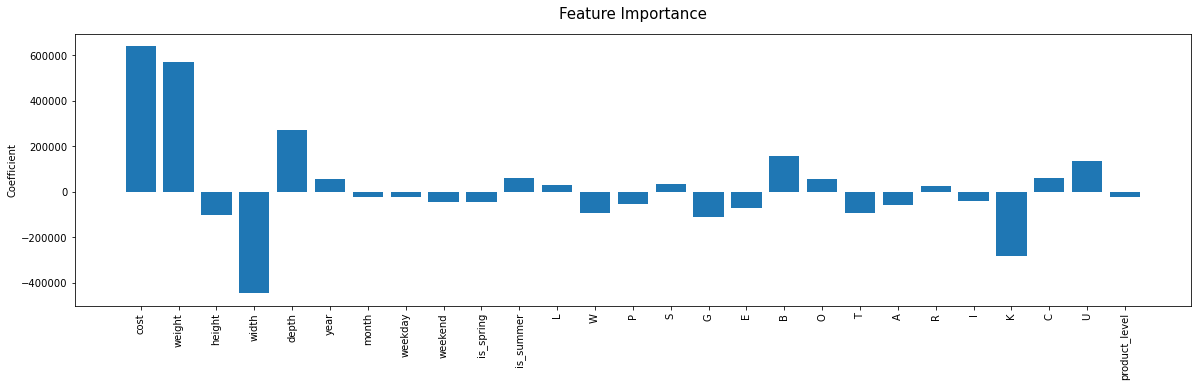

In [65]:
# Visualize the feature importance
ridge_pipeline_coef = ridge_pipeline.steps[1][1].coef_

coeff_cutoff = 20000
large_features = X_train_tfm.columns[np.abs(ridge_pipeline_coef)>coeff_cutoff]
coeff = ridge_pipeline_coef[np.abs(ridge_pipeline_coef)>coeff_cutoff]
plt.figure(figsize=(20,5))
plt.bar(x=large_features, height=coeff)
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)

Linear regression model (Lasso) with all features:
- Train loss metrics (MAE, MSE, R2) are: (9.84e+04, 2.01e+10, 0.571)
- Test loss metrics (MAE, MSE, R2) are: (1.11e+05, 3.55e+10, 0.364)

Linear regression model (Lasso) with all features sans ingredient:
- Train loss metrics (MAE, MSE, R2) are: (1.12e+05, 2.72e+10, 0.418)
- Test loss metrics (MAE, MSE, R2) are: (1.19e+05, 3.71e+10, 0.336)

Linear regression model (Ridge) with all features:
- Train loss metrics (MAE, MSE, R2) are: (1.12e+05, 2.72e+10, 0.418)
- Test loss metrics (MAE, MSE, R2) are: (1.19e+05, 3.71e+10, 0.336)

The Ridge model using all features turned out to have the same performance (and feature importance) as the Lasso model with all features sans ingredient. So far the best model candidate is still the the Lasso model with all features.

**(4) Lasso model with power transformation of the cost feature and the price target**

Linear regression models typically assume variables to be normally distributed. However, from the exploratory data analysis we knew that the cost feature and the price target are heavily skewed. Therefore, we may want to further investigate the impact of power tranformation of these two variables in order to improve model prediction accuracy.

In [66]:
# Get numerical features ready for scaling/modeling
# no power transformation
numeric_t = numeric_transformer()

# Get time features ready for scaling/modeling
date_t = Pipeline([
    ('selector', FeatureSelector('purchase_date')),
    ('date_tfm', date_transformer())
    ])

# Get categorical features ready for modeling    
ptype_t = Pipeline([
    ('selector', FeatureSelector('product_type')),
    ('ptype_tfm', ptype_transformer())
    ])
plevel_t = Pipeline([
    ('selector', FeatureSelector('product_level')),
    ('plevel_tfm', plevel_transformer())
    ])    
ingredient_t = Pipeline([
    ('selector', FeatureSelector('ingredient')),
    ('ingredient_tfm', ingredient_transformer())
    ]) 

# Transform training set to a DataFrame ready for further scaling or modeling
tfms = [numeric_t, date_t, ptype_t, plevel_t, ingredient_t]    

X_train_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.fit_transform(X_train))
    X_train_tfm = pd.concat([X_train_tfm, df_sub], axis = 1)

X_train_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,395000.000000,3380.0,267.0,104.0,27.0,2015,1,9,5,False,...,False,False,False,False,False,False,False,False,False,False
1,169135.774648,2880.0,238.0,101.0,27.0,2012,12,14,5,False,...,False,False,False,False,False,False,False,False,False,False
2,66000.000000,3040.0,269.0,98.0,26.0,2010,12,24,5,False,...,False,False,False,False,False,False,False,False,False,False
3,169135.774648,3210.0,253.0,104.0,27.0,1999,6,25,5,False,...,False,False,False,False,False,False,False,False,False,False
4,169135.774648,3110.0,258.0,101.0,26.0,1996,11,29,5,False,...,False,False,False,False,False,False,False,False,False,False


In [67]:
X_test_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.transform(X_test))
    X_test_tfm = pd.concat([X_test_tfm, df_sub], axis = 1)

X_test_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,317000.000000,2990.0,289.0,94.0,25.0,2007,9,28,5,False,...,False,False,False,False,False,False,False,False,False,False
1,23000.000000,3130.0,291.0,96.0,25.0,2012,2,17,5,False,...,False,False,False,False,False,False,False,False,False,False
2,169135.774648,2980.0,260.0,99.0,26.0,2008,11,7,5,False,...,False,False,False,False,False,False,False,False,False,False
3,254000.000000,3470.0,269.0,105.0,27.0,2001,10,5,5,False,...,False,False,False,False,False,False,False,False,False,False
4,144000.000000,2840.0,253.0,98.0,26.0,2001,4,6,5,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
# Power transformation of the cost feature for the training set
power_cost = PowerTransformer(method='yeo-johnson', standardize=False)
X_train_tfm['cost'] = power_cost.fit_transform(X_train_tfm['cost'].values.reshape(len(X_train_tfm['cost']),1))
print("The fitted lambda for the training set is: ", power_cost.lambdas_)

X_train_tfm.head()

The fitted lambda for the training set is:  [0.30705039]


,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,167.048449,3380.0,267.0,104.0,27.0,2015,1,9,5,False,...,False,False,False,False,False,False,False,False,False,False
1,128.000331,2880.0,238.0,101.0,27.0,2012,12,14,5,False,...,False,False,False,False,False,False,False,False,False,False
2,95.061701,3040.0,269.0,98.0,26.0,2010,12,24,5,False,...,False,False,False,False,False,False,False,False,False,False
3,128.000331,3210.0,253.0,104.0,27.0,1999,6,25,5,False,...,False,False,False,False,False,False,False,False,False,False
4,128.000331,3110.0,258.0,101.0,26.0,1996,11,29,5,False,...,False,False,False,False,False,False,False,False,False,False


In [69]:
power_price = PowerTransformer(method='yeo-johnson', standardize=False)
y_train_power = pd.Series(power_price.fit_transform(y_train.values.reshape(len(y_train),1)).reshape(-1))
print("The fitted lambda for the test set is: ", power_price.lambdas_)

The fitted lambda for the test set is:  [0.06384094]


In [70]:
# Define how to scale the features
numerical_col = X_train_tfm.select_dtypes(include=['int64', 'float64']).columns
categorical_col = X_train_tfm.select_dtypes(include=['object', 'bool']).columns
scale_numeric = ColumnTransformer(transformers=[
    ('num_scale', MinMaxScaler(), numerical_col),
    ('cat_scale', NoScaler(), categorical_col)
    ])

In [71]:
# Tune hyperparameter for Lasso model
X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_train_tfm, y_train_power, test_size=0.33, random_state=0)
training_error = []
validation_error = []

alphas = [0.005, 0.01, 0.02, 0.03, 0.05] # Manually iterated on value range

for alpha in alphas:
    # Build Lasso pipeline
    steps = [('scale', scale_numeric),
             ('lasso', Lasso(alpha=alpha, random_state=0, max_iter=10000))]
    lasso_pipeline = Pipeline(steps)
    lasso_pipeline.fit(X_tune_train, y_tune_train)
    training_error.append(mean_squared_error(
        power_price.inverse_transform(y_tune_train.values.reshape(len(y_tune_train),1)),
        power_price.inverse_transform(lasso_pipeline.predict(X_tune_train).reshape(len(y_tune_train),1))
        ))
    validation_error.append(mean_squared_error(
        power_price.inverse_transform(y_tune_test.values.reshape(len(y_tune_test),1)),
        power_price.inverse_transform(lasso_pipeline.predict(X_tune_test).reshape(len(y_tune_test),1))
        ))

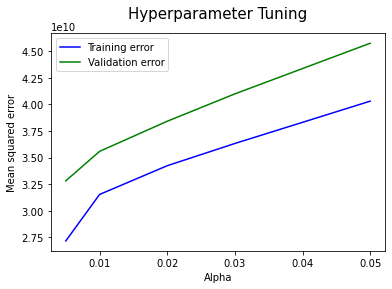

In [72]:
# Hyperparameter tuning visualization 
plt.plot(alphas, training_error, color='blue', label='Training error')
plt.plot(alphas, validation_error, color='green', label='Validation error')
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
#plt.ylim([])
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

In [73]:
# Set alpha = 0.01 based on hyperparameter tuning results
steps = [('scale', scale_numeric),
         ('lasso', Lasso(alpha=0.01, random_state=0))]
lasso_pipeline = Pipeline(steps)
lasso_pipeline.fit(X_train_tfm, y_train_power)

Pipeline(steps=[('scale',
                 ColumnTransformer(transformers=[('num_scale', MinMaxScaler(),
                                                  Index(['cost', 'weight', 'height', 'width', 'depth', 'year', 'month', 'day',
       'weekday', 'product_level'],
      dtype='object')),
                                                 ('cat_scale', NoScaler(),
                                                  Index(['weekend', 'is_spring', 'is_summer', 'is_fall', 'L', 'W', 'P', 'J', 'N',
       'S',
       ...
       'IN732529', 'IN733732', 'IN733909', 'IN733184', 'IN733700', 'IN732284',
       'IN732943', 'IN733145', 'IN732729', 'IN732373'],
      dtype='object', length=1939))])),
                ('lasso', Lasso(alpha=0.01, random_state=0))])

In [74]:
# Power transformation of the cost feature for the test set
X_test_tfm['cost'] = power_cost.transform(X_test_tfm['cost'].values.reshape(len(X_test_tfm['cost']),1))

# Power transformation of the price target for the test set
# y_test_power = pd.Series(power_price.transform(y_test.values.reshape(len(y_test),1)).reshape(-1))

In [75]:
y_train_pred = power_price.inverse_transform(lasso_pipeline.predict(X_train_tfm).reshape(len(y_train),1))
y_test_pred = power_price.inverse_transform(lasso_pipeline.predict(X_test_tfm).reshape(len(y_test),1))

# Evaluate model performance
print("Train loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_train,y_train_pred),
             mean_squared_error(y_train,y_train_pred),
            r2_score(y_train,y_train_pred)))
print("Test loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_test,y_test_pred),
             mean_squared_error(y_test,y_test_pred),
            r2_score(y_test,y_test_pred)))

Train loss metrics (MAE, MSE, R2) are: (1.05e+05, 3.32e+10, 0.290)
Test loss metrics (MAE, MSE, R2) are: (1.10e+05, 4.30e+10, 0.230)


Text(0.5, 1.0, 'Feature Importance')

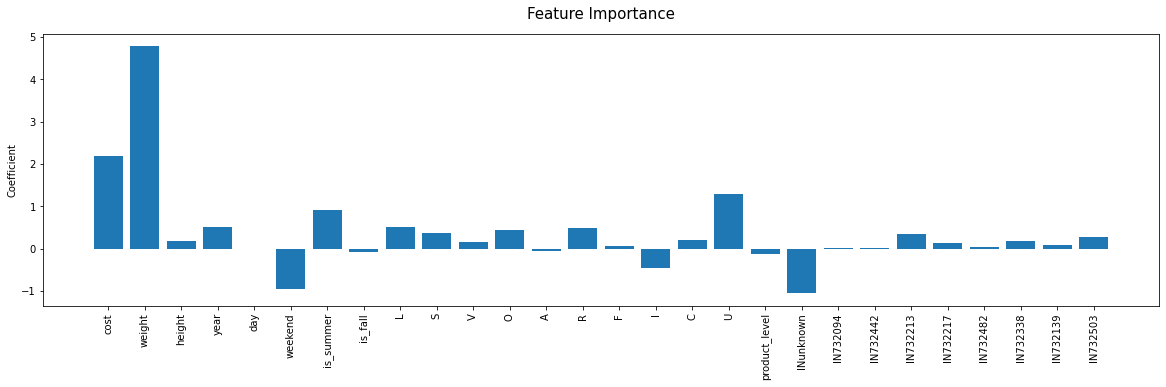

In [76]:
# Visualize the feature importance
lasso_pipeline_coef = lasso_pipeline.steps[1][1].coef_

coeff_cutoff = 0.002
large_features = X_train_tfm.columns[np.abs(lasso_pipeline_coef)>coeff_cutoff]
coeff = lasso_pipeline_coef[np.abs(lasso_pipeline_coef)>coeff_cutoff]
plt.figure(figsize=(20,5))
plt.bar(x=large_features, height=coeff)
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance', pad=15, size=15)

Linear regression model (Lasso) with all features:
- Train loss metrics (MAE, MSE, R2) are: (9.84e+04, 2.01e+10, 0.571)
- Test loss metrics (MAE, MSE, R2) are: (1.11e+05, 3.55e+10, 0.364)

Linear regression model (Lasso) with all features, where power transformation was applied to the cost feature and the price target:
- Train loss metrics (MAE, MSE, R2) are: (1.05e+05, 3.32e+10, 0.290)
- Test loss metrics (MAE, MSE, R2) are: (1.10e+05, 4.30e+10, 0.230)

Power transformation of the cost feature and the price target did not improve model performance. 

**(5) Random forest model**

Although the linear regression models provide decent prediction, these models all assume linear relations between features and the target variable, which may not necessarily be the underlying pattern of this dataset. Therefore, a non-linear random forest model is built whose performance will be compared to the best candidate so far (Lasso model with all features).

In [77]:
# Get numerical features ready for modeling
# Random forest does not require scaling or assume normal distribution, thus no further processing
numeric_t = numeric_transformer()

# Get time features ready for scaling/modeling
date_t = Pipeline([
    ('selector', FeatureSelector('purchase_date')),
    ('date_tfm', date_transformer())
    ])

# Get categorical features ready for modeling    
ptype_t = Pipeline([
    ('selector', FeatureSelector('product_type')),
    ('ptype_tfm', ptype_transformer())
    ])
plevel_t = Pipeline([
    ('selector', FeatureSelector('product_level')),
    ('plevel_tfm', plevel_transformer())
    ])    
ingredient_t = Pipeline([
    ('selector', FeatureSelector('ingredient')),
    ('ingredient_tfm', ingredient_transformer())
    ]) 

# Transform training set to a DataFrame ready for further scaling or modeling
tfms = [numeric_t, date_t, ptype_t, plevel_t, ingredient_t]    

X_train_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.fit_transform(X_train))
    X_train_tfm = pd.concat([X_train_tfm, df_sub], axis = 1)

X_train_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,395000.000000,3380.0,267.0,104.0,27.0,2015,1,9,5,False,...,False,False,False,False,False,False,False,False,False,False
1,169135.774648,2880.0,238.0,101.0,27.0,2012,12,14,5,False,...,False,False,False,False,False,False,False,False,False,False
2,66000.000000,3040.0,269.0,98.0,26.0,2010,12,24,5,False,...,False,False,False,False,False,False,False,False,False,False
3,169135.774648,3210.0,253.0,104.0,27.0,1999,6,25,5,False,...,False,False,False,False,False,False,False,False,False,False
4,169135.774648,3110.0,258.0,101.0,26.0,1996,11,29,5,False,...,False,False,False,False,False,False,False,False,False,False


In [78]:
X_test_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.transform(X_test))
    X_test_tfm = pd.concat([X_test_tfm, df_sub], axis = 1)

X_test_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,317000.000000,2990.0,289.0,94.0,25.0,2007,9,28,5,False,...,False,False,False,False,False,False,False,False,False,False
1,23000.000000,3130.0,291.0,96.0,25.0,2012,2,17,5,False,...,False,False,False,False,False,False,False,False,False,False
2,169135.774648,2980.0,260.0,99.0,26.0,2008,11,7,5,False,...,False,False,False,False,False,False,False,False,False,False
3,254000.000000,3470.0,269.0,105.0,27.0,2001,10,5,5,False,...,False,False,False,False,False,False,False,False,False,False
4,144000.000000,2840.0,253.0,98.0,26.0,2001,4,6,5,False,...,False,False,False,False,False,False,False,False,False,False


In [79]:
# Build a Random Forest regression model and tune hyperparameters using k-fold cross validation
# (Note: this block takes about 10 min to run)
rf_model = RandomForestRegressor(random_state=0, n_jobs=-1)

scorer = make_scorer(mean_squared_error, greater_is_better=False)

param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 10],
              'min_samples_leaf': range(30, 150, 30), 'min_samples_split': [2, 3, 5]}

rf_model_gsv = GridSearchCV(rf_model, param_grid, cv = 3, scoring = scorer, return_train_score=True)

rf_model_gsv.fit(X_train_tfm, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': range(30, 150, 30),
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

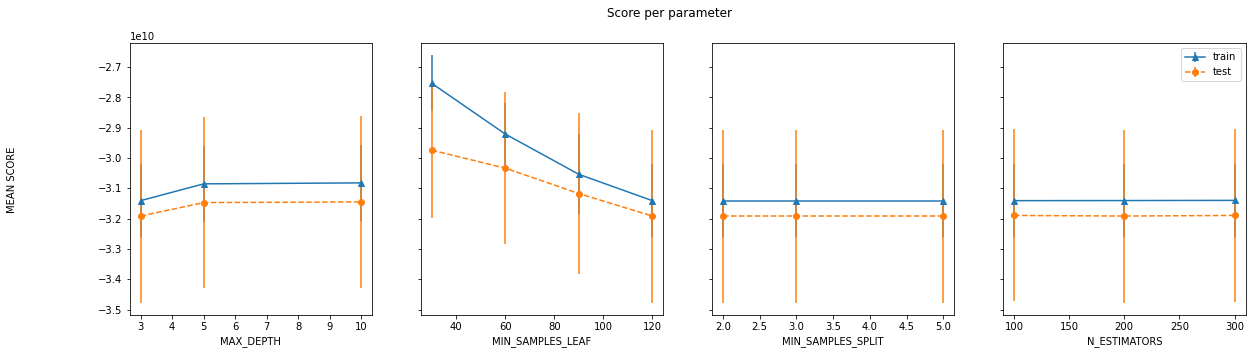

In [80]:
# Visualize gridsearchcv results
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    cv_results = pd.DataFrame(grid.cv_results_)
    params = grid.best_params_.keys()
    num_params = len(params)
    
    fig, axes = plt.subplots(1, num_params, squeeze=False, sharex='none',
                             sharey='all', figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')

    for i, param in enumerate(params):
        param_group = cv_results.groupby(f'param_{param}')
        x = param_group.groups.keys()
        means_train = param_group['mean_train_score'].min()
        e_1 = cv_results.loc[param_group.idxmin()['mean_train_score'], 'std_train_score']
        means_test = param_group['mean_test_score'].min()
        e_2 = cv_results.loc[param_group.idxmin()['mean_test_score'], 'std_test_score']

        axes[0, i].errorbar(x, means_train, e_1, linestyle='-', marker='^', label='train')
        axes[0, i].errorbar(x, means_test, e_2, linestyle='--', marker='o', label='test')

        axes[0, i].set_xlabel(param.upper())

    plt.legend()

plot_search_results(rf_model_gsv)

Observations from the first round of hyperparameter tuning:
- Both train and test scores increase as max_depth increases from 3 to 5, and the scores with max_depth of 10 are very close to those with max_depth of 10. For further tuning of the model, max_depth may be set between 5 and 10.
- Both train and test scores drop as min_samples_leaf increases. The decreasing train score indicates increasing bias, which is undesirable. However, the difference between the train score and the test score appears to be decreasing as min_samples_leaf changes from 30 to 90, suggesting a reduction in variance. Considering this tradeoff between bias and variance, further tuning in this range can be useful with other parameters set at their optimal values.
- The model is not sensitive to min_samples_split and n_estimators within the screened ranges. Default values will be selected (min_samples_split=2, n_estimators=100) moving forward.

In [81]:
# Fine tune hyperparameters for the Random Forest regression model
rf_model2 = RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=100, min_samples_split=2)

param_grid2 = {'max_depth': [5, 7, 9],
              'min_samples_leaf': range(30, 91, 20)}

rf_model_gsv2 = GridSearchCV(rf_model2, param_grid2, cv = 3, scoring = scorer, return_train_score=True)

rf_model_gsv2.fit(X_train_tfm, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [5, 7, 9],
                         'min_samples_leaf': range(30, 91, 20)},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

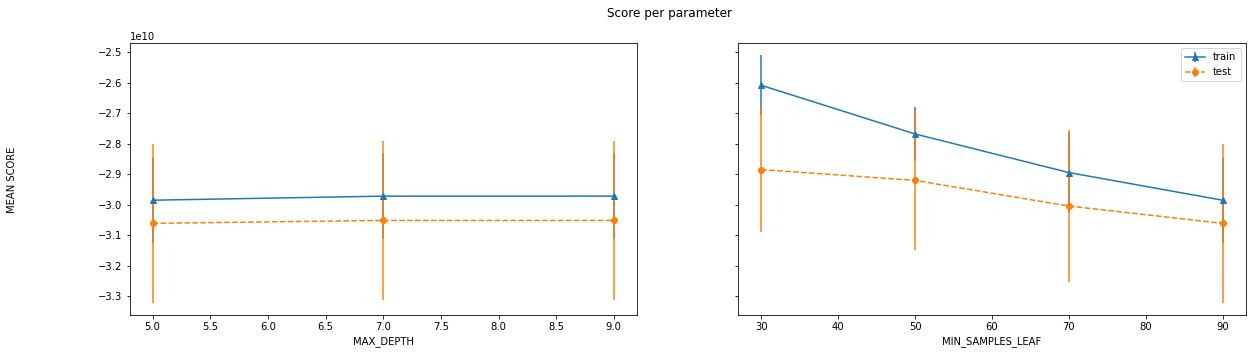

In [82]:
# Visualize gridsearchcv results
plot_search_results(rf_model_gsv2)

In [83]:
# Set max_depth = 70 and min_samples_leaf = 50 based on hyperparameter tuning results
rf_model_opt = RandomForestRegressor(random_state=0, n_jobs=-1,
                                     n_estimators=100, min_samples_split=2,
                                    max_depth = 70, min_samples_leaf = 50)

rf_model_opt.fit(X_train_tfm, y_train)

y_train_pred = rf_model_opt.predict(X_train_tfm)
y_test_pred = rf_model_opt.predict(X_test_tfm)

# Evaluate model performance
print("Train loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_train,y_train_pred),
             mean_squared_error(y_train,y_train_pred),
            r2_score(y_train,y_train_pred)))
print("Test loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_test,y_test_pred),
             mean_squared_error(y_test,y_test_pred),
            r2_score(y_test,y_test_pred)))

Train loss metrics (MAE, MSE, R2) are: (1.01e+05, 2.65e+10, 0.434)
Test loss metrics (MAE, MSE, R2) are: (1.06e+05, 3.59e+10, 0.358)


In [84]:
rf_model_opt.feature_importances_

array([0.86502562, 0.04664596, 0.00857721, ..., 0.        , 0.        ,
       0.        ])

Text(0.5, 1.0, 'Feature Importance (top 15)')

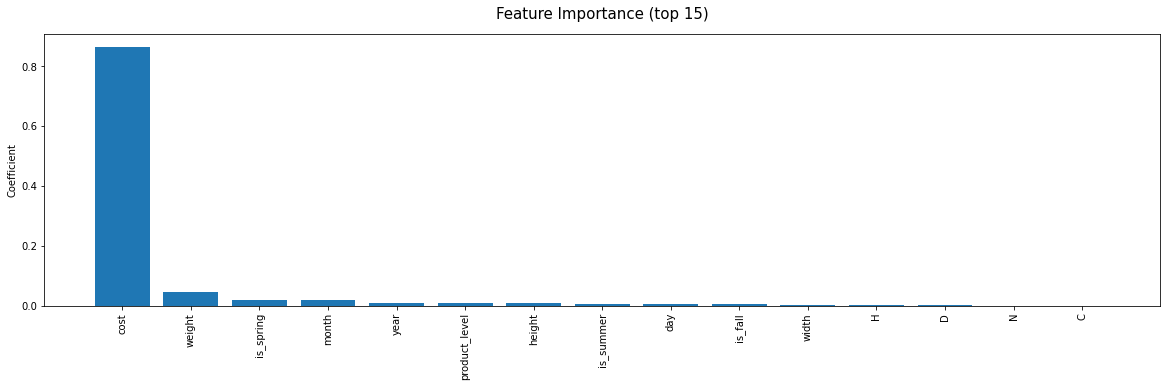

In [85]:
# Visualize feature importance
feature_importance = pd.Series(rf_model_opt.feature_importances_, index=X_train_tfm.columns)

x = feature_importance.sort_values(ascending=False)[:15].index
height = feature_importance.sort_values(ascending=False)[:15].values
plt.figure(figsize=(20,5))
plt.bar(x=x, height=height)
plt.ylabel('Coefficient')
plt.xticks(rotation='vertical')
plt.title('Feature Importance (top 15)', pad=15, size=15)

Linear regression model (Lasso) with all features:
- Train loss metrics (MAE, MSE, R2) are: (9.84e+04, 2.01e+10, 0.571)
- Test loss metrics (MAE, MSE, R2) are: (1.11e+05, 3.55e+10, 0.364)

Random Forest regression model with all features:
- Train loss metrics (MAE, MSE, R2) are: (1.01e+05, 2.65e+10, 0.434)
- Test loss metrics (MAE, MSE, R2) are: (1.06e+05, 3.59e+10, 0.358)

Compared with the Lasso model, the Random Forest regression model has higher bias, slightly lower prediction accuray, and lower variance. Both models have pros and cons and it is not straightforward to justify one model better than the other. Both models may be utilized to make predictions in the future and further improved when new dataset becomes available to incorporate.

Both the Lasso model and the Random Forest regression models have built-in feature selection, but the feature importance results are somewhat different. For the Random Forest regression model, the cost feature is the single most important feature. The weight feature ranks number two but falls far behind the cost feature. For the Lasso regression model, cost was also observed to be the most important feature. In addition, weight and several ingredients were found to have relatively high coeffients as well. Considering that the ingredients matrix are sparse, the importance of these "important" ingredients in predicting new dataset is uncertain. Therefore, we have more confidence at this point to say cost is the most important feature to predict price, followed by weight. From the Lasso model coefficients we also know that price is positively related to cost and weight.

**(6) Lasso model with kNN imputation of the cost feature**

Because the cost feature is an important if not the most important variable for predicting price, the operation on this variable, such as handling missing values may have a significant impact on model performance. Therefore, a different imputation method (i.e., kNN imputation) for the numerica features (cost, weight, height, depth, width) is assessed for its impact using Lasso model as an example.

In [96]:
from sklearn.impute import KNNImputer

In [120]:
# Build a transformer class to convert string values to numeric values for numerical features

class numeric_transformer:
    ''' 
    Transform any or all of the numerical features
    (cost, weight, height, width, and depth)
    from string values to numeric values.
    Missing values are not handled.
    ---
    Input: X, Dataframe (as long as it contains the five features above)
    Output: DataFrame
    '''

    def __init__(self):
        None
    
    def fit(self, X, y=None):
        df_numeric = pd.DataFrame()
        if 'cost' in X.columns:
            df_numeric['cost'] = X['cost'].map(self.cost2num)
        if 'weight' in X.columns:
            df_numeric['weight'] = X['weight'].map(self.weight2num)
        if 'height' in X.columns:
            df_numeric['height'] = X['height'].map(self.height2num)
        if 'width' in X.columns:
            df_numeric['width'] = X['width'].map(self.width2num)        
        if 'depth' in X.columns:
            df_numeric['depth'] = X['depth'].map(self.depth2num)

    def transform(self, X, y=None):
        df_numeric = pd.DataFrame()
        if 'cost' in X.columns:
            df_numeric['cost'] = X['cost'].map(self.cost2num)
        if 'weight' in X.columns:
            df_numeric['weight'] = X['weight'].map(self.weight2num)
        if 'height' in X.columns:
            df_numeric['height'] = X['height'].map(self.height2num)
        if 'width' in X.columns:
            df_numeric['width'] = X['width'].map(self.width2num)        
        if 'depth' in X.columns:
            df_numeric['depth'] = X['depth'].map(self.depth2num)
        return df_numeric
 
    def fit_transform(self, X, y=None):       
        self.fit(X)
        return self.transform(X)
        
    # Convert cost string to numeric (unit: $)        
    def cost2num(self, x):
        if type(x) == str:
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

    # Convert weight string to numeric (unit: kg)
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip('Kg').strip().split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
    
    # Convert height string to numeric (unit: cm)
    def height2num(self, x):
        if type(x) == str:
            x = x.strip('meters').strip()
            return float(x)*100
        else:
            return x        
    
    # Convert width string to numeric (unit: cm)
    def width2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

    # Convert depth string to numeric (unit: cm)
    def depth2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

In [121]:
numeric_t = numeric_transformer()
X_train_num = numeric_t.fit_transform(X_train)
knnimputer = KNNImputer()
X_train_num = pd.DataFrame(knnimputer.fit_transform(X_train_num),
                           columns=['cost', 'weight', 'height', 'width', 'depth'])

In [122]:
# Get time features ready for scaling/modeling
date_t = Pipeline([
    ('selector', FeatureSelector('purchase_date')),
    ('date_tfm', date_transformer())
    ])

# Get categorical features ready for modeling    
ptype_t = Pipeline([
    ('selector', FeatureSelector('product_type')),
    ('ptype_tfm', ptype_transformer())
    ])
plevel_t = Pipeline([
    ('selector', FeatureSelector('product_level')),
    ('plevel_tfm', plevel_transformer())
    ])    
ingredient_t = Pipeline([
    ('selector', FeatureSelector('ingredient')),
    ('ingredient_tfm', ingredient_transformer())
    ]) 

# Transform training set to a DataFrame ready for further scaling or modeling
tfms = [date_t, ptype_t, plevel_t, ingredient_t]    

X_train_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.fit_transform(X_train))
    X_train_tfm = pd.concat([X_train_tfm, df_sub], axis = 1)

X_train_tfm = pd.concat([X_train_num, X_train_tfm], axis = 1)
    
X_train_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,395000.0,3380.0,267.0,104.0,27.0,2015,1,9,5,False,...,False,False,False,False,False,False,False,False,False,False
1,66800.0,2880.0,238.0,101.0,27.0,2012,12,14,5,False,...,False,False,False,False,False,False,False,False,False,False
2,66000.0,3040.0,269.0,98.0,26.0,2010,12,24,5,False,...,False,False,False,False,False,False,False,False,False,False
3,134000.0,3210.0,253.0,104.0,27.0,1999,6,25,5,False,...,False,False,False,False,False,False,False,False,False,False
4,159200.0,3110.0,258.0,101.0,26.0,1996,11,29,5,False,...,False,False,False,False,False,False,False,False,False,False


In [123]:
X_test_num = numeric_t.transform(X_test)
X_test_num = pd.DataFrame(knnimputer.transform(X_test_num),
                           columns=['cost', 'weight', 'height', 'width', 'depth'])

X_test_tfm = pd.DataFrame()
for t in tfms:
    df_sub = pd.DataFrame(t.transform(X_test))
    X_test_tfm = pd.concat([X_test_tfm, df_sub], axis = 1)

X_test_tfm = pd.concat([X_test_num, X_test_tfm], axis = 1)
    
X_test_tfm.head()

,cost,weight,height,width,depth,year,month,day,weekday,weekend,...,IN732529,IN733732,IN733909,IN733184,IN733700,IN732284,IN732943,IN733145,IN732729,IN732373
0,317000.0,2990.0,289.0,94.0,25.0,2007,9,28,5,False,...,False,False,False,False,False,False,False,False,False,False
1,23000.0,3130.0,291.0,96.0,25.0,2012,2,17,5,False,...,False,False,False,False,False,False,False,False,False,False
2,82000.0,2980.0,260.0,99.0,26.0,2008,11,7,5,False,...,False,False,False,False,False,False,False,False,False,False
3,254000.0,3470.0,269.0,105.0,27.0,2001,10,5,5,False,...,False,False,False,False,False,False,False,False,False,False
4,144000.0,2840.0,253.0,98.0,26.0,2001,4,6,5,False,...,False,False,False,False,False,False,False,False,False,False


In [124]:
# Define how to scale the features
numerical_col = X_train_tfm.select_dtypes(include=['int64', 'float64']).columns
categorical_col = X_train_tfm.select_dtypes(include=['object', 'bool']).columns
scale_numeric = ColumnTransformer(transformers=[
    ('num_scale', MinMaxScaler(), numerical_col),
    ('cat_scale', NoScaler(), categorical_col)
    ])

In [133]:
# Tune hyperparameter for Lasso model
X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_train_tfm, y_train, test_size=0.33, random_state=0)
training_error = []
validation_error = []

alphas = range(200, 501, 25) # Manually iterated on value range

for alpha in alphas:
    # Build Lasso pipeline
    steps = [('scale', scale_numeric),
             ('lasso', Lasso(alpha=alpha, random_state=0, max_iter=10000))]
    lasso_pipeline = Pipeline(steps)
    lasso_pipeline.fit(X_tune_train, y_tune_train)
    training_error.append(mean_squared_error(y_tune_train, lasso_pipeline.predict(X_tune_train)))
    validation_error.append(mean_squared_error(y_tune_test, lasso_pipeline.predict(X_tune_test)))

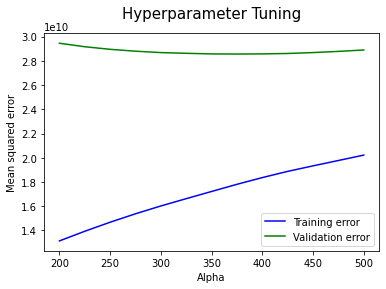

In [134]:
# Hyperparameter tuning visualization 
plt.plot(alphas, training_error, color='blue', label='Training error')
plt.plot(alphas, validation_error, color='green', label='Validation error')
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
#plt.ylim([])
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

In [135]:
# Set alpha = 350 based on hyperparameter tuning results
steps = [('scale', scale_numeric),
         ('lasso', Lasso(alpha=350, random_state=0))]
lasso_pipeline = Pipeline(steps)
lasso_pipeline.fit(X_train_tfm, y_train)

# Evaluate model performance
print("Train loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_train,lasso_pipeline.predict(X_train_tfm)),
             mean_squared_error(y_train,lasso_pipeline.predict(X_train_tfm)),
            r2_score(y_train,lasso_pipeline.predict(X_train_tfm))))
print("Test loss metrics (MAE, MSE, R2) are: ({0:.2e}, {1:.2e}, {2:.3f})".
      format(mean_absolute_error(y_test,lasso_pipeline.predict(X_test_tfm)),
             mean_squared_error(y_test,lasso_pipeline.predict(X_test_tfm)),
            r2_score(y_test,lasso_pipeline.predict(X_test_tfm)))) 

Train loss metrics (MAE, MSE, R2) are: (9.79e+04, 2.02e+10, 0.568)
Test loss metrics (MAE, MSE, R2) are: (1.10e+05, 3.49e+10, 0.375)


Linear regression model (Lasso) with all features, impute with mean:
- Train loss metrics (MAE, MSE, R2) are: (9.84e+04, 2.01e+10, 0.571)
- Test loss metrics (MAE, MSE, R2) are: (1.11e+05, 3.55e+10, 0.364)

Linear regression model (Lasso) with all features, impute with kNN:
- Train loss metrics (MAE, MSE, R2) are: (9.79e+04, 2.02e+10, 0.568)
- Test loss metrics (MAE, MSE, R2) are: (1.10e+05, 3.49e+10, 0.375)
    
With kNN imputation, the model seems to show slight improvement on variance. 

## Summary

In this project, machine learning models were built to predict the price of future purchases of product XoX for our customers. Several models were built and tested, including linear regression models (Lasso and Ridge) and non-linear regression model (Random Tree). The impact of power transformation (on the cost feature and the price target) and imputation method (mean vs. knn on numeric features) was examined on the Lasso model with the goal to improve model performance. 

One linear regression model and one non-linear regression model were selected to be the top model candidates. Their performance on the training and test sets is summerized below:

Linear regression model (Lasso) with all features, impute with kNN:
- Train loss metrics (MAE, MSE, R2) are: (9.79e+04, 2.02e+10, 0.568)
- Test loss metrics (MAE, MSE, R2) are: (1.10e+05, 3.49e+10, 0.375)
    
Random Forest regression model with all features, impute with mean:
- Train loss metrics (MAE, MSE, R2) are: (1.01e+05, 2.65e+10, 0.434)
- Test loss metrics (MAE, MSE, R2) are: (1.06e+05, 3.59e+10, 0.358)

The Random Forest regression model has higher bias, slightly lower prediction accuray, and lower variance, compared with the Lasso model. Both models have their strengths, so it is recommended that both models are utilized to make predictions. 

Both models showed that the cost feature is the most important feature for price prediction. The second most important feature is weight, although its importance is far below that of the cost feature. From the Lasso model coefficients we also know that price is positively related to cost and weight.